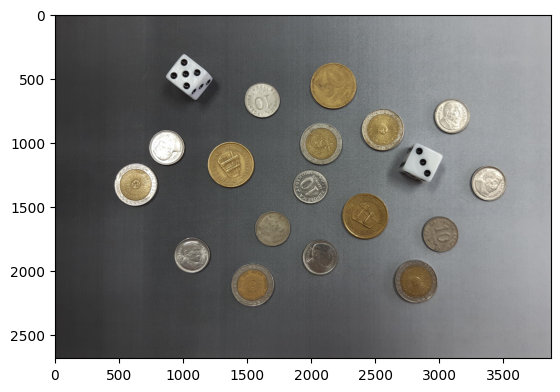

In [668]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

IMG="images/monedas.jpg"

img = cv2.imread(IMG)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)

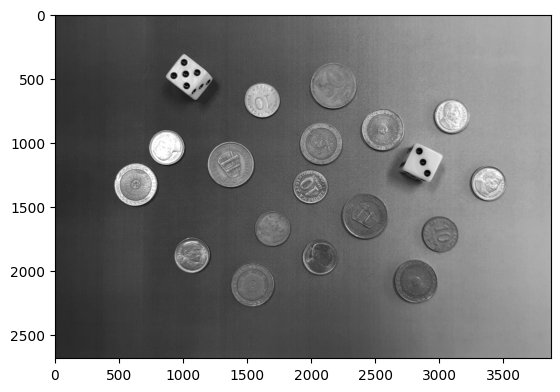

In [669]:
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
f_blur = cv2.GaussianBlur(img_gray, ksize=(7, 7), sigmaX=0, sigmaY=0)
#fdenoised = cv2.fastNlMeansDenoisingColored(f_blur,None,10,10,7,21)
plt.imshow(f_blur, cmap="gray")



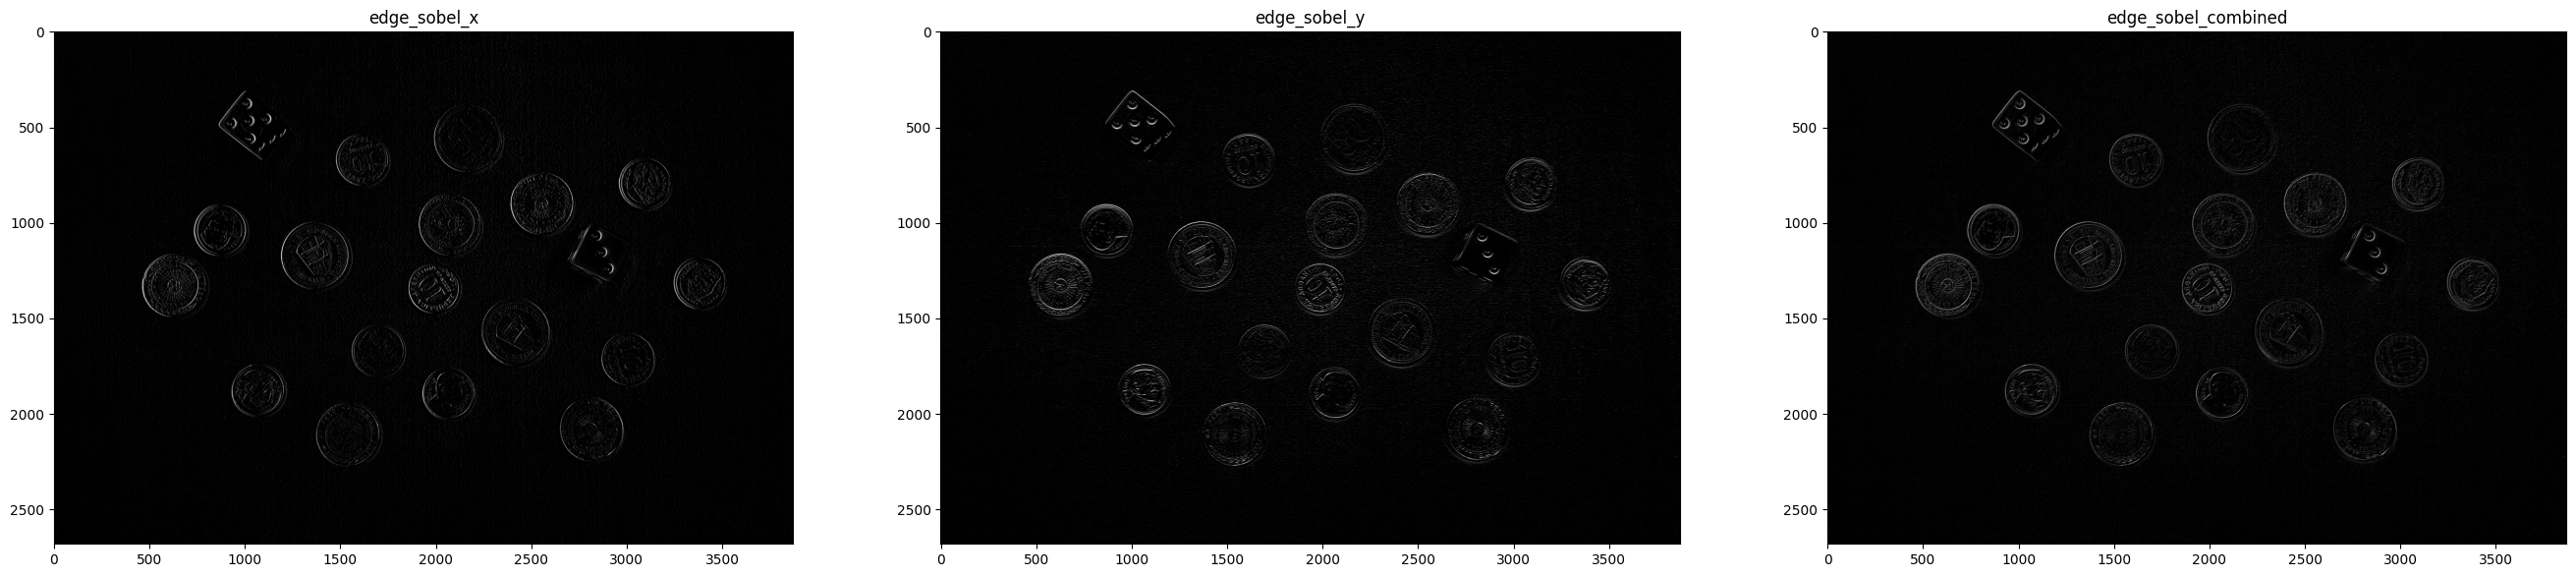

In [670]:
sobel_map = {}
sobel_map["edge_sobel_x"] = cv2.Sobel(f_blur, -1, 1, 0, ksize=3)
sobel_map["edge_sobel_y"] = cv2.Sobel(f_blur, -1, 0, 1, ksize=3)
sobel_map["edge_sobel_combined"] = cv2.addWeighted(sobel_map["edge_sobel_x"], 0.5, sobel_map["edge_sobel_y"], 0.5, 0)

plt.figure(figsize=(33,33))
sub_plot_id=230
for key, value in sobel_map.items():
    sub_plot_id +=1 
    plt.subplot(sub_plot_id, title=key)
    plt.imshow(value, cmap="gray")


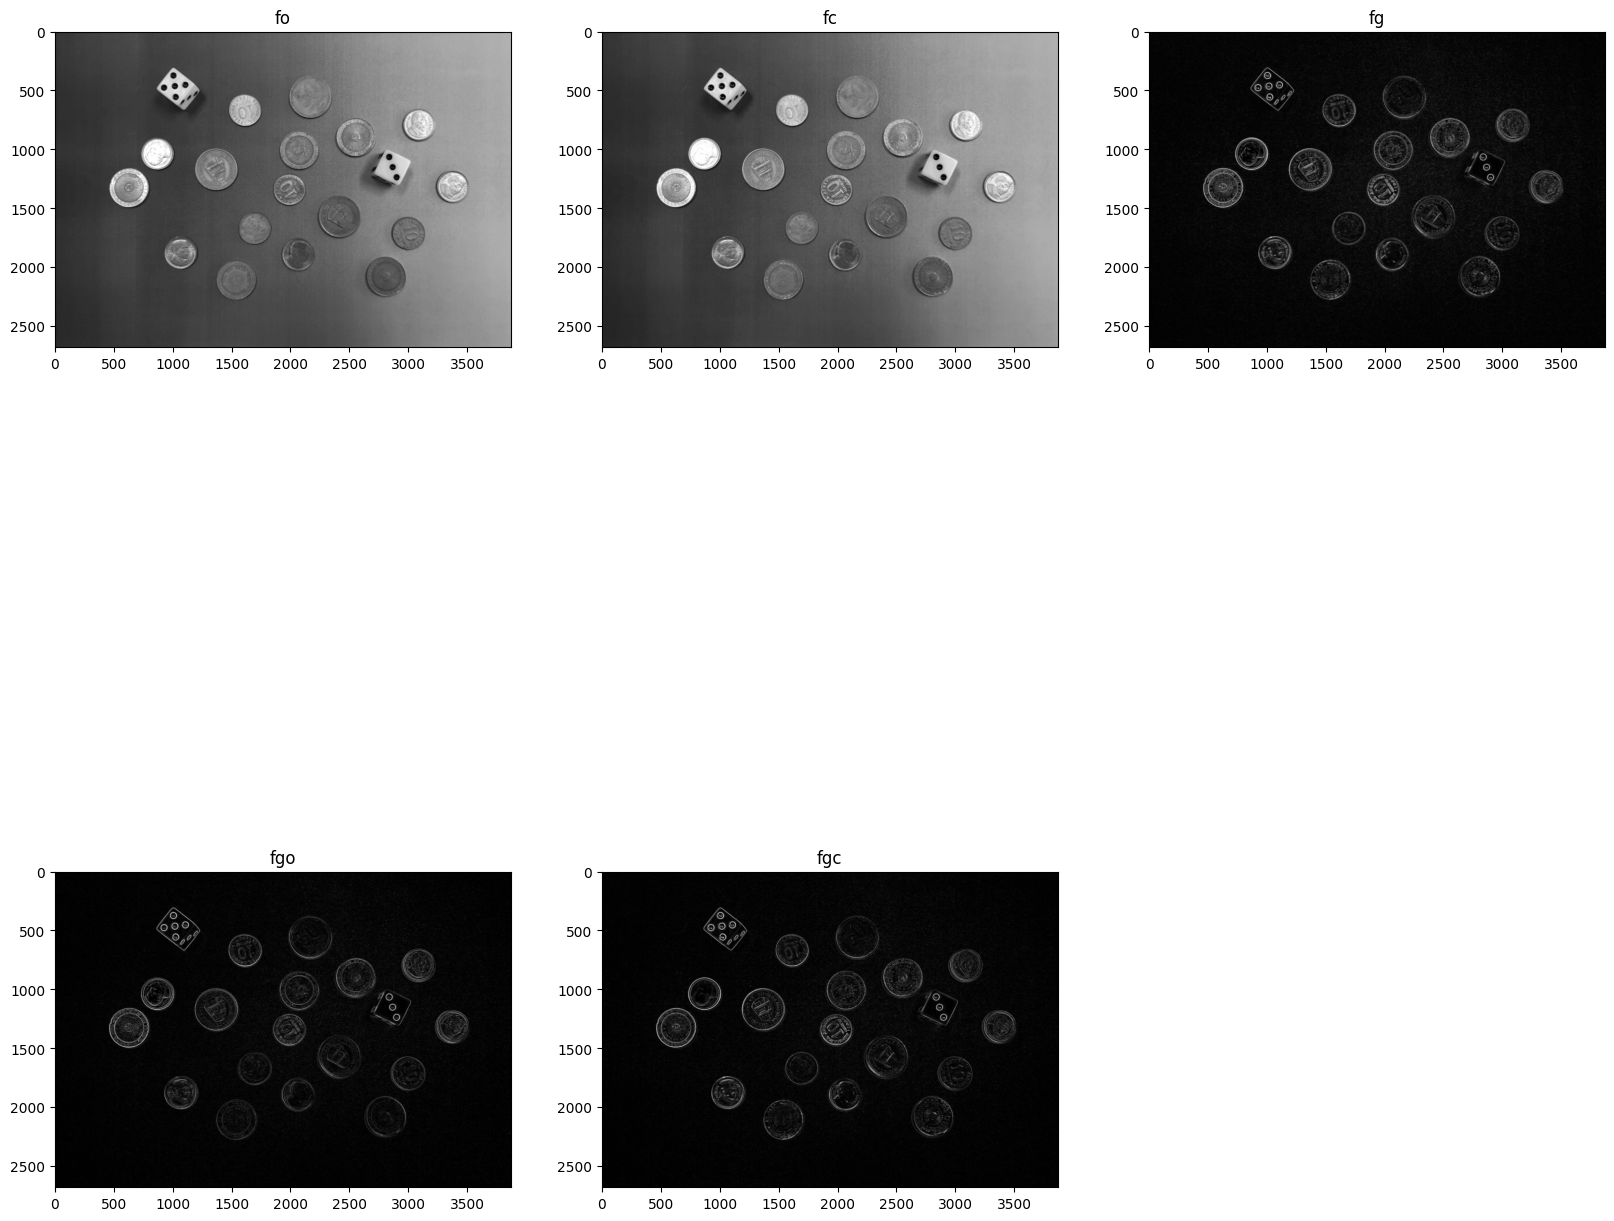

In [671]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))

morph = {}
morph["fo"] = cv2.morphologyEx(f_blur, cv2.MORPH_OPEN, kernel)
morph["fc"] = cv2.morphologyEx(f_blur, cv2.MORPH_CLOSE, kernel)
morph["fg"] = cv2.morphologyEx(f_blur, cv2.MORPH_GRADIENT, kernel)
morph["fgo"] = cv2.morphologyEx(morph["fo"], cv2.MORPH_GRADIENT, kernel)
morph["fgc"] = cv2.morphologyEx(morph["fc"], cv2.MORPH_GRADIENT, kernel)

plt.figure(figsize=(20,20))
sub_plot_id=230

for key, value in morph.items():
    sub_plot_id +=1 
    plt.subplot(sub_plot_id, title=key)
    plt.imshow(value, cmap="gray")



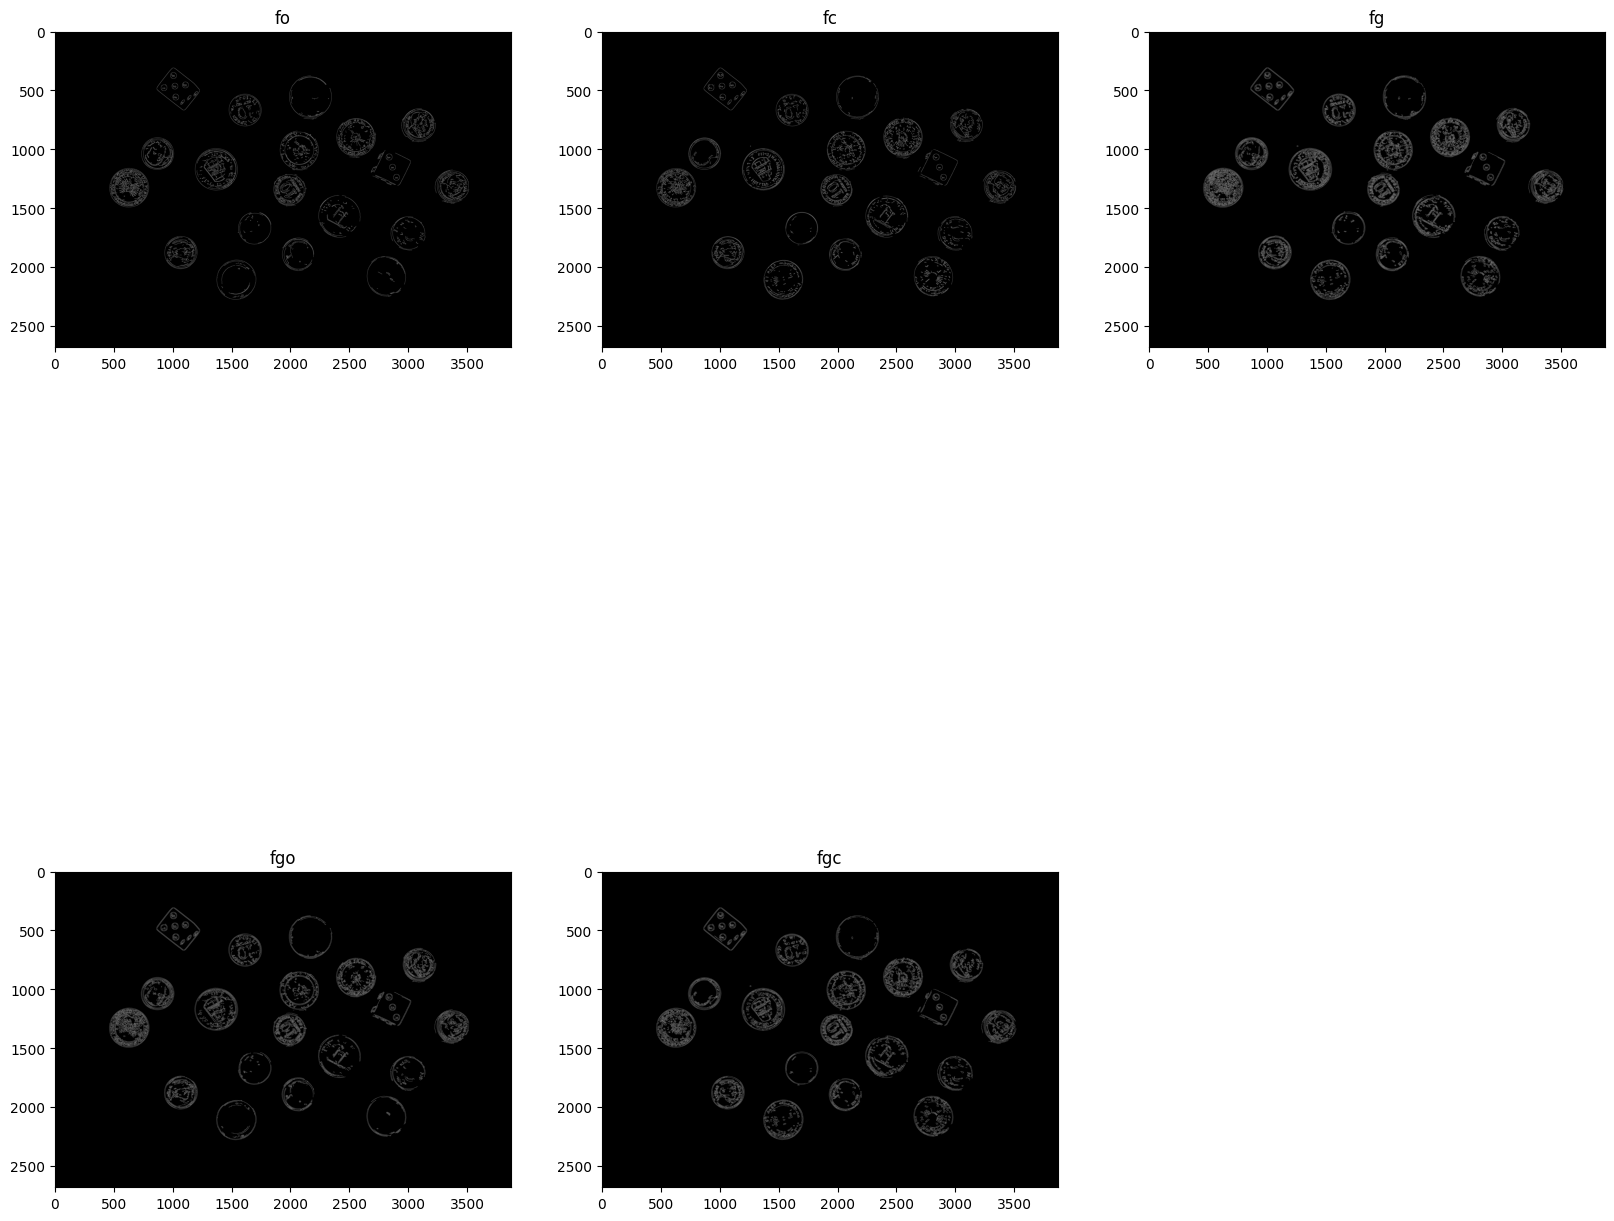

In [672]:

canny = {}

plt.figure(figsize=(20,20))
sub_plot_id=230

for key, value in morph.items():
    sub_plot_id +=1 
    canny[key] = cv2.Canny(value, 35, 90, apertureSize=3, L2gradient=True)
    plt.subplot(sub_plot_id, title=key)
    plt.imshow(canny[key], cmap="gray")



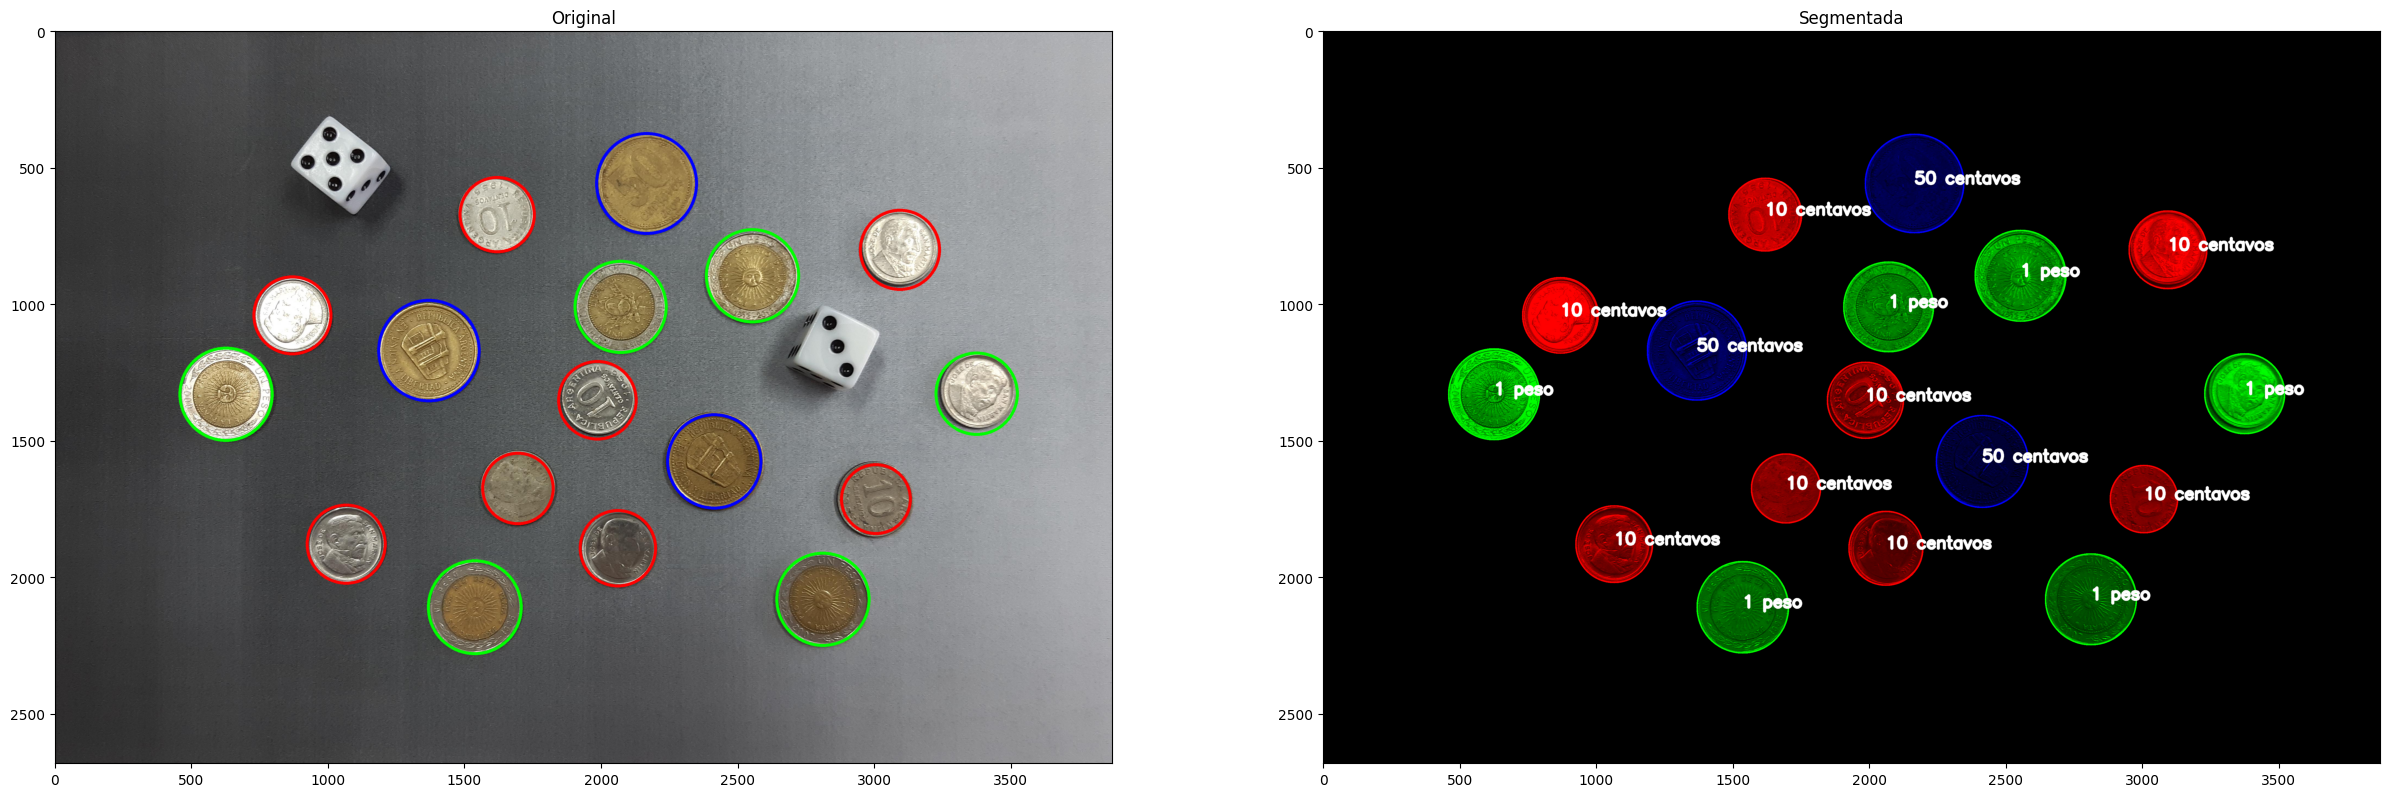

In [673]:
coins_map = {
    "10c" : {
        "radio" : (120,145),
        "color" : (255,0,0),
        "valor" : 0.10,
        "name" : "10 centavos",
        "mask" : []
    },
    "50c" : {
        "radio" : (145,170),
        "color" : (0,255,0),
        "valor" : 0.50,
        "name" : "1 peso",
        "mask" : []
    },
    "1p" : {
        "radio" : (170,500),
        "color" : (0,0,255),
        "valor" : 1.0,
        "name" : "50 centavos",
        "mask" : []
    }
}

font = cv2.FONT_HERSHEY_SIMPLEX 
fontScale = 2
fontColor = (255, 255, 255)   
thickness = 10

dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
canny_dilate_circles = cv2.dilate(canny["fgc"],dilate_kernel,iterations = 3)

coins =  cv2.HoughCircles(
            canny_dilate_circles,  # source image (blurred and grayscaled)
            cv2.HOUGH_GRADIENT,  # type of detection
            1.7,  # inverse ratio of accumulator res. to image res.
            300,  # minimum distance between the centers of circles
            param1=255,  # Gradient value passed to edge detection
            param2=100, # accumulator threshold for the circle centers
            minRadius=60, 
            maxRadius=200
        )

output = img_rgb.copy()
result = np.zeros_like(output, np.uint8) 

mask_circles = np.zeros_like(output, np.uint8) 
mask_circles = mask_circles[:,:,0]

for coin in coins[0]:
    x_coor, y_coor, detected_radius = coin
    x_coor, y_coor, detected_radius = int(x_coor), int(y_coor), int(detected_radius) 
    
    key = None 
    if detected_radius > coins_map["10c"]["radio"][0] and detected_radius <= coins_map["10c"]["radio"][1]:
        key = "10c"
    elif detected_radius > coins_map["1p"]["radio"][0] and detected_radius <= coins_map["1p"]["radio"][1]:
        key = "1p"
    elif detected_radius > coins_map["50c"]["radio"][0] and detected_radius <= coins_map["50c"]["radio"][1]:
        key = "50c"
    else:
        continue
    
    coins_map[key]["mask"].append([x_coor, y_coor, detected_radius])
    
    output = cv2.circle(output, (x_coor, y_coor), detected_radius, coins_map[key]["color"], thickness=10)
    mask = np.zeros_like(output, np.uint8)
    mask = cv2.circle(mask, (x_coor, y_coor), detected_radius, [255]*3, thickness=cv2.FILLED)
    mask = mask[:,:,0]
    mask_circles += mask
    color_src = np.full_like(output, fill_value=coins_map[key]["color"])
    result = cv2.bitwise_and( color_src, output , dst=result, mask=mask)
    cv2.putText(result, coins_map[key]["name"], (x_coor, y_coor), font,  fontScale, fontColor, thickness, cv2.LINE_AA)
    
plt.figure(figsize=(30,30))
plt.subplot(221, title="Original")
plt.imshow(output)

plt.subplot(222, title="Segmentada")
plt.imshow(result)    

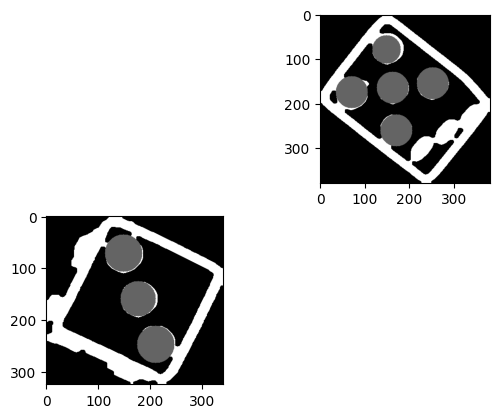

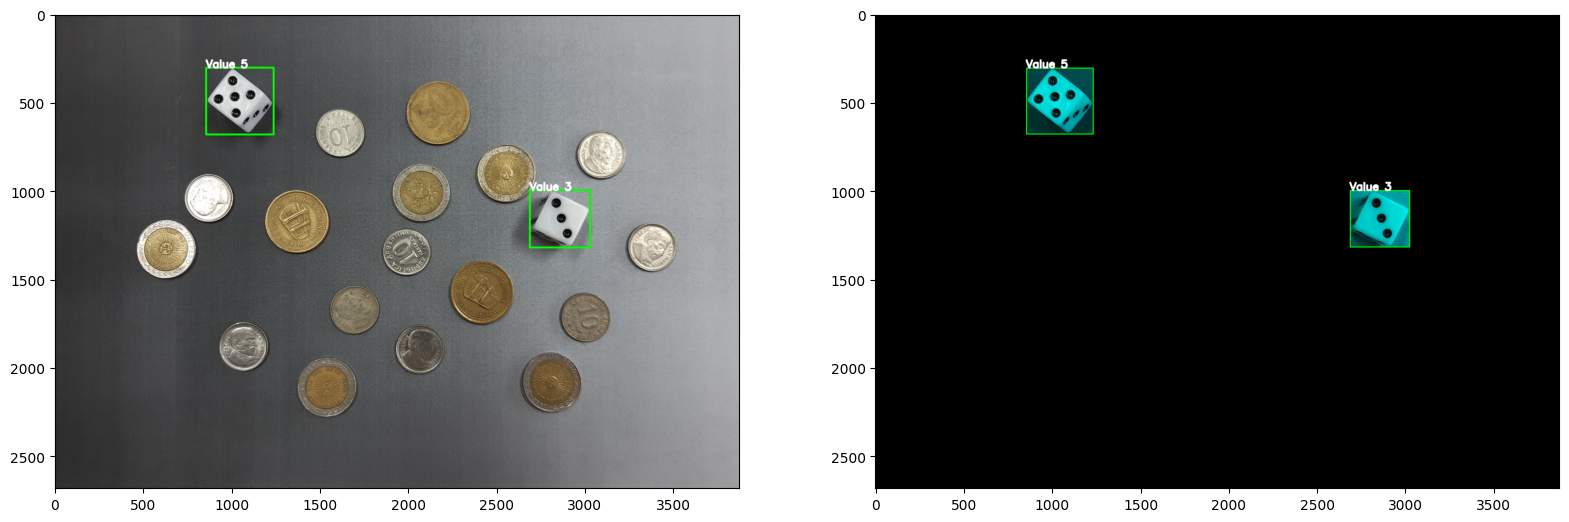

In [674]:

mask_dices = canny["fc"]
img_rgb_copy=img_rgb.copy()

for c in coins_map.values():
   for x_coor, y_coor, detected_radius in c["mask"]:
    cv2.circle(mask_dices, (x_coor, y_coor), detected_radius+50, [0]*3, thickness=-1)

dilate_kernel = np.array([[0,1,0],[1,1,1],[0,1,0]], np.uint8)
mask_dices = cv2.dilate(mask_dices,kernel,iterations = 3)

n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_dices, connectivity=4)

dices = []
final_mask_dices =  np.zeros_like(mask_dices, np.uint8) 
for i in range(1, n_labels):
    area = stats[i, cv2.CC_STAT_AREA]  

    if area > 10000:

        x1 = stats[i, cv2.CC_STAT_LEFT] 
        y1 = stats[i, cv2.CC_STAT_TOP] 
        w = stats[i, cv2.CC_STAT_WIDTH] 
        h = stats[i, cv2.CC_STAT_HEIGHT]        
        p1 = (x1,y1)
        p2 = (x1+w, y1+h)
        
        dices.append({"coord": (p1,p2) , "img": mask_dices[y1:y1+h, x1:x1+w]})
        componentMask = (labels == i).astype("uint8") * 255
        final_mask_dices = cv2.rectangle( final_mask_dices, p1, p2, [255]*3, thickness=-1)
        img_rgb_copy= cv2.rectangle( img_rgb_copy, p1, p2, (0,255,0), thickness=10)


color_mark_mask = np.full_like(img_rgb_copy, fill_value=(0,255,255))
final_result_dices = cv2.bitwise_and(color_mark_mask,img_rgb_copy,  mask=final_mask_dices)

sub=221
kernel_dice = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
for dice in dices:
    
    dice["img"] = cv2.morphologyEx(dice["img"], cv2.MORPH_OPEN, kernel_dice, iterations=1)
    dice["img"] = cv2.morphologyEx(dice["img"], cv2.MORPH_CLOSE, kernel_dice,iterations=1) 

    vals =  cv2.HoughCircles(
            dice["img"],  # source image (blurred and grayscaled)
            cv2.HOUGH_GRADIENT,  # type of detection
            2,  # inverse ratio of accumulator res. to image res.
            10,  # minimum distance between the centers of circles
            param1=255,  # Gradient value passed to edge detection
            param2=30, # accumulator threshold for the circle centers
            minRadius=30, 
            maxRadius=40
        )

    for val in vals[0] :
        x_coor, y_coor, detected_radius = val
        x_coor, y_coor, detected_radius = int(x_coor), int(y_coor), int(detected_radius)        
        dice["img"] = cv2.circle(dice["img"], (x_coor, y_coor), detected_radius, (100,0,0), thickness=cv2.FILLED)

    dice_value = len(vals[0])
    cv2.putText( final_result_dices, f"Value {dice_value}", dice["coord"][0], font,  fontScale, fontColor, thickness, cv2.LINE_AA)
    cv2.putText( img_rgb_copy, f"Value {dice_value}", dice["coord"][0], font,  fontScale, fontColor, thickness, cv2.LINE_AA) 
    
    sub+=1
    plt.subplot(sub)
    plt.imshow(dice["img"], cmap="gray")

plt.figure(figsize=(30,30))
plt.subplot(231)
plt.imshow(img_rgb_copy)
plt.subplot(232)
plt.imshow(final_result_dices)


# Final